# CS 480/680 assignment 4

Tips:
- Please save a copy of this notebook to avoid losing your changes.
- Debug your code and ensure that it can run.
- Save the output of each cell. Failure to do so may result in your coding questions not being graded.
- To accelerate the training time, you can choose 'Runtime' -> 'Change runtime type' -> 'Hardware accelerator' and set 'Hardware accelerator' to 'GPU'.
- Your grade is independent of the accuracy of your models. Your grade will depend on the correctness of your code and implementation.

Tips for submission:
- Do not change the order of the problems.
- Select 'Runtime' -> 'Run all' to run all cells and generate a final "gradable" version of your notebook and save your ipynb file.
- Also use 'File' -> 'Print' and then print your report from your browser into a PDF file.

##Question1 - Adversarial Training (55 points)

In this assignment, you are supposed to train a model using limited data that, in addition to generalization, also possesses good robustness.


You can add any extra libraries that you need in this cell.

In [1]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
import umap
from tqdm import tqdm
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
# import torchattacks

In [2]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Q1.1 Load Data (5 points)

In this question, you are going to use CIFAR-10 dataset. First, load this dataset, then split 20% of the data for training and the rest for validation. Make sure to maintain class balance during the split.

In [3]:
TRAIN_SIZE = 0.2
cifar_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Cifar10Dataset(torch.utils.data.Dataset):

    def __init__(self,dataset,idx,transforms=None):
        self.idx = idx
        self.transforms = transforms
        self.data = torch.utils.data.Subset(dataset, idx)

    def __getitem__(self,index):
        image,label = self.data[index]
        if(self.transforms!= None):
            image = self.transforms(image)

        return image,label

    def __len__(self):
        return len(self.data)

#Split data and create the dataloader
BATCH_SIZE = 256
FGSM_EPS = 8 / 255

labels = cifar_trainset.targets
train_idx, val_idx = train_test_split(range(len(labels)), train_size=TRAIN_SIZE, stratify=labels)

train = Cifar10Dataset(cifar_trainset,train_idx,cifar_transforms)
val = Cifar10Dataset(cifar_trainset,val_idx,cifar_transforms)
test = Cifar10Dataset(cifar_testset,range(len(cifar_testset)),cifar_transforms)

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val, batch_size=len(val))
test_loader = torch.utils.data.DataLoader(test, batch_size=len(test))

###Q1.2 Train Model (15 points)

Train a ResNet18 model using the cross-entropy loss function, and report its accuracy on validation and test datasets.

After that, reduce the dimensionality of the output of the backbone of the network and visualize it for the unseen data. You can use UMAP for dimensionality reduction. Note that for this task, you are not allowed to use the labels.

In [5]:
class Resnet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = models.resnet18(num_classes=num_classes)

    def forward(self, x):
        return self.resnet(x)

In [6]:
def train(model,data_loader,criterion,optimizer,attack=False, eval=False):
    model.train()
    average_train_loss = 0

    with tqdm(data_loader, desc="train") as train_tqdm:
        for batch_idx, (inputs, targets) in enumerate(train_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)

            if attack is True:
                # attacker = torchattacks.FGSM(model, eps=FGSM_EPS)
                # inputs = attacker(inputs, targets)
                inputs = fast_gradient_method(model, inputs, eps=FGSM_EPS, norm=np.inf)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            average_train_loss += loss.item()
    average_train_loss /= len(data_loader)
    
    accuracy = None
    if eval is True:
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                predictions = nn.functional.softmax(outputs, dim=1).argmax(dim=1)
                accuracy += (predictions == targets).sum().item()
        accuracy /= len(data_loader.dataset)

    return average_train_loss, accuracy


N_EPOCHS = 50
NUM_CLASSES = 10
EVAL_INTERVAL = 100

In [7]:
net = Resnet18(NUM_CLASSES).to(device)

for epoch in range(N_EPOCHS):
    eval = epoch % EVAL_INTERVAL == 0 or epoch == N_EPOCHS - 1
    
    average_train_loss, accuracy = train(net, train_loader, nn.CrossEntropyLoss(), torch.optim.Adam(net.parameters()), eval=eval)
    print(f"   Epoch {epoch + 1} - Train Loss: {average_train_loss} - Accuracy: {accuracy}")

train: 100%|██████████| 40/40 [00:02<00:00, 17.26it/s]


   Epoch 1 - Train Loss: 1.7654459327459335 - Accuracy: 0.3565


train: 100%|██████████| 40/40 [00:01<00:00, 20.92it/s]


   Epoch 2 - Train Loss: 1.5191361963748933 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 21.03it/s]


   Epoch 3 - Train Loss: 1.2944569736719131 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.47it/s]


   Epoch 4 - Train Loss: 1.1033603996038437 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 21.12it/s]


   Epoch 5 - Train Loss: 0.9609625101089477 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.34it/s]


   Epoch 6 - Train Loss: 0.8188116773962975 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.29it/s]


   Epoch 7 - Train Loss: 0.6846846856176854 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 21.00it/s]


   Epoch 8 - Train Loss: 0.5896531142294407 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.24it/s]


   Epoch 9 - Train Loss: 0.5125830538570881 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.45it/s]


   Epoch 10 - Train Loss: 0.4595571911893785 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


   Epoch 11 - Train Loss: 0.42116104774177077 - Accuracy: None


train: 100%|██████████| 40/40 [00:02<00:00, 19.68it/s]


   Epoch 12 - Train Loss: 0.3837648889049888 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.48it/s]


   Epoch 13 - Train Loss: 0.33180087748914955 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.39it/s]


   Epoch 14 - Train Loss: 0.2950288946740329 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.48it/s]


   Epoch 15 - Train Loss: 0.2659025126136839 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.13it/s]


   Epoch 16 - Train Loss: 0.22386236805468798 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.50it/s]


   Epoch 17 - Train Loss: 0.21496035233139993 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.21it/s]


   Epoch 18 - Train Loss: 0.18672247021459043 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.01it/s]


   Epoch 19 - Train Loss: 0.20473681690637022 - Accuracy: None


train: 100%|██████████| 40/40 [00:02<00:00, 19.90it/s]


   Epoch 20 - Train Loss: 0.18170609697699547 - Accuracy: None


train: 100%|██████████| 40/40 [00:02<00:00, 19.80it/s]


   Epoch 21 - Train Loss: 0.16643565613776445 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.41it/s]


   Epoch 22 - Train Loss: 0.15753871076740325 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.80it/s]


   Epoch 23 - Train Loss: 0.15648874575272204 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


   Epoch 24 - Train Loss: 0.15094105019234122 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.38it/s]


   Epoch 25 - Train Loss: 0.1304745134431869 - Accuracy: None


train: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


   Epoch 26 - Train Loss: 0.11755717084743082 - Accuracy: None


train: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s]


   Epoch 27 - Train Loss: 0.12168091621715575 - Accuracy: None


train: 100%|██████████| 40/40 [00:02<00:00, 19.49it/s]


   Epoch 28 - Train Loss: 0.11489516193978488 - Accuracy: None


train: 100%|██████████| 40/40 [00:02<00:00, 19.37it/s]


   Epoch 29 - Train Loss: 0.11454905159771442 - Accuracy: None


train: 100%|██████████| 40/40 [00:02<00:00, 19.99it/s]


   Epoch 30 - Train Loss: 0.10266461665742099 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.48it/s]


   Epoch 31 - Train Loss: 0.09534817177336663 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.88it/s]


   Epoch 32 - Train Loss: 0.0953314274083823 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


   Epoch 33 - Train Loss: 0.09521110202185809 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.80it/s]


   Epoch 34 - Train Loss: 0.08025801095645875 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.66it/s]


   Epoch 35 - Train Loss: 0.08583664704929106 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.90it/s]


   Epoch 36 - Train Loss: 0.07881144245620816 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.81it/s]


   Epoch 37 - Train Loss: 0.08459062802139669 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.87it/s]


   Epoch 38 - Train Loss: 0.07378497485769912 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 21.00it/s]


   Epoch 39 - Train Loss: 0.07615587203763426 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.94it/s]


   Epoch 40 - Train Loss: 0.0782209527445957 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.95it/s]


   Epoch 41 - Train Loss: 0.0687062747310847 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.92it/s]


   Epoch 42 - Train Loss: 0.07160187198314816 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.90it/s]


   Epoch 43 - Train Loss: 0.06193068472493905 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.80it/s]


   Epoch 44 - Train Loss: 0.06263472909340635 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.06it/s]


   Epoch 45 - Train Loss: 0.0655844506341964 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.34it/s]


   Epoch 46 - Train Loss: 0.06660915273241699 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.52it/s]


   Epoch 47 - Train Loss: 0.06124878826667555 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.47it/s]


   Epoch 48 - Train Loss: 0.058613245593733154 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.58it/s]


   Epoch 49 - Train Loss: 0.07220450927270576 - Accuracy: None


train: 100%|██████████| 40/40 [00:01<00:00, 20.68it/s]


   Epoch 50 - Train Loss: 0.06587991816923022 - Accuracy: 0.9845


In [8]:
def test(model,data_loader,criterion):
    model.eval()
    average_test_loss = 0
    accuracy = 0

    with tqdm(data_loader, desc ="test") as test_tqdm, torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            average_test_loss += loss.item()

            predictions = nn.functional.softmax(outputs, dim=1).argmax(dim=1)
            accuracy += (predictions == targets).sum().item()
    average_test_loss /= len(data_loader)
    accuracy /= len(data_loader.dataset)

    return average_test_loss, accuracy


In [9]:
average_val_loss, accuracy = test(net, val_loader, nn.CrossEntropyLoss())
print(f"   Validation Loss: {average_val_loss} - Accuracy: {accuracy}")
average_test_loss, accuracy = test(net, test_loader, nn.CrossEntropyLoss())
print(f"   Test Loss: {average_test_loss} - Accuracy: {accuracy}")

test: 100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


   Validation Loss: 2.7717628479003906 - Accuracy: 0.601025


test: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

   Test Loss: 2.853787422180176 - Accuracy: 0.5957


In [10]:
def plot_umap(features,y):
    reducer = umap.UMAP()
    result = reducer.fit_transform(features)
    plt.figure()
    plt.scatter(result[:, 0], result[:, 1], c=y, cmap='tab10', s=5)
    plt.colorbar()
    plt.show()

In [11]:
feature_net = nn.Sequential(*list(net.resnet.children())[:-1]).to(device)

feature_net.eval()
net.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        features = feature_net(inputs).squeeze().cpu().numpy()
        y_test = nn.functional.softmax(net(inputs), dim=1).argmax(dim=1).cpu().numpy()

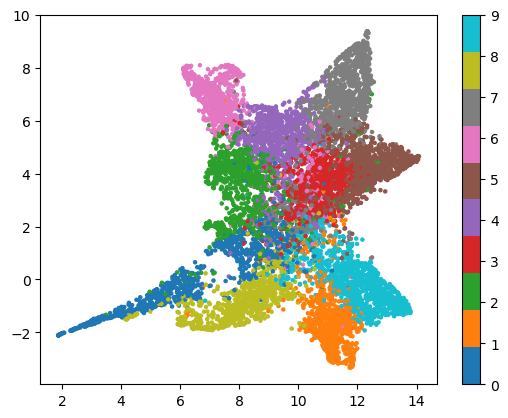

In [12]:
plot_umap(features,y_test)

###Q1.3 Adversarial Test (15 points)


In this section, you are required to change the unseen data before calculating the accuracy of them from the output image of the backbone. Compare the results with the previous section. Your changes should include data augmentations such as adding Gaussian noise, color jitter, etc. Additionally, you should apply an adversarial attack such as fast gradient method on the network. You can use the cleverhans library for this purpose.

In [13]:
augmentation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.GaussianBlur(3),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    # transforms.RandomRotation(20),
                                   ])

train_aug = Cifar10Dataset(cifar_trainset,train_idx,augmentation)
val_aug = Cifar10Dataset(cifar_trainset,val_idx,augmentation)
test_aug = Cifar10Dataset(cifar_testset,range(len(cifar_testset)),augmentation)

train_loader_aug = torch.utils.data.DataLoader(train_aug, batch_size=BATCH_SIZE)
val_loader_aug = torch.utils.data.DataLoader(val_aug, batch_size=len(val_aug))
test_loader_aug = torch.utils.data.DataLoader(test_aug, batch_size=len(test_aug))

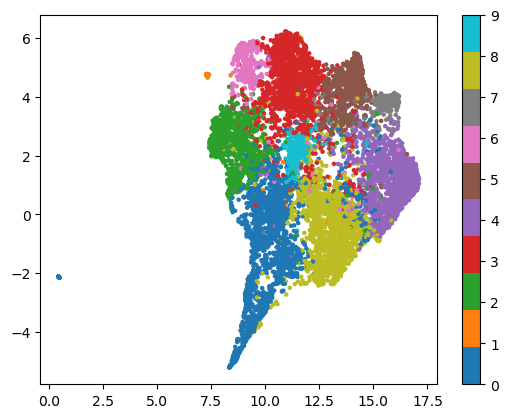

In [14]:
net.eval()
feature_net.eval()
with torch.no_grad():
    for inputs, outputs in test_loader_aug:
        inputs = inputs.to(device)
        with torch.enable_grad():
            # attacker = torchattacks.FGSM(model, eps=FGSM_EPS)
            # inputs = attacker(inputs, outputs)
            inputs = fast_gradient_method(net, inputs, eps=FGSM_EPS, norm=np.inf)
        features = feature_net(inputs).squeeze().cpu().numpy()
        advy_test = nn.functional.softmax(net(inputs), dim=1).argmax(dim=1).cpu().numpy()

plot_umap(features,advy_test)

##Q1.4 Adversarial Train (20 points)


In this section, you should repeat the experiments on parts two and three using adversarial examples and compare the results. Here, the training data will be modified using augmentations and adversarial attack.

In [15]:
#Train resnet18 using the adversarial examples
robust_net = Resnet18(NUM_CLASSES).to(device)

for epoch in range(N_EPOCHS):
    eval = epoch % EVAL_INTERVAL == 0 or epoch == N_EPOCHS - 1
    
    average_train_loss, accuracy = train(robust_net, train_loader_aug, nn.CrossEntropyLoss(), torch.optim.Adam(robust_net.parameters()), eval=eval, attack=True)
    print(f"   Epoch {epoch + 1} - Train Loss: {average_train_loss} - Accuracy: {accuracy}")

train: 100%|██████████| 40/40 [00:15<00:00,  2.57it/s]


   Epoch 1 - Train Loss: 2.090756046772003 - Accuracy: 0.3389


train: 100%|██████████| 40/40 [00:18<00:00,  2.19it/s]


   Epoch 2 - Train Loss: 1.9180580139160157 - Accuracy: None


train: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


   Epoch 3 - Train Loss: 1.7972144216299057 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.51it/s]


   Epoch 4 - Train Loss: 1.7204061031341553 - Accuracy: None


train: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s]


   Epoch 5 - Train Loss: 1.6378674298524856 - Accuracy: None


train: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


   Epoch 6 - Train Loss: 1.561021801829338 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.50it/s]


   Epoch 7 - Train Loss: 1.4855933606624603 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.55it/s]


   Epoch 8 - Train Loss: 1.4213015258312225 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.65it/s]


   Epoch 9 - Train Loss: 1.3435857802629472 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.53it/s]


   Epoch 10 - Train Loss: 1.2934683457016944 - Accuracy: None


train: 100%|██████████| 40/40 [00:14<00:00,  2.68it/s]


   Epoch 11 - Train Loss: 1.2673705145716667 - Accuracy: None


train: 100%|██████████| 40/40 [00:14<00:00,  2.76it/s]


   Epoch 12 - Train Loss: 1.2087607845664023 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.59it/s]


   Epoch 13 - Train Loss: 1.161457833647728 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.64it/s]


   Epoch 14 - Train Loss: 1.114621539413929 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]


   Epoch 15 - Train Loss: 1.0796694785356522 - Accuracy: None


train: 100%|██████████| 40/40 [00:14<00:00,  2.69it/s]


   Epoch 16 - Train Loss: 1.023219606280327 - Accuracy: None


train: 100%|██████████| 40/40 [00:14<00:00,  2.72it/s]


   Epoch 17 - Train Loss: 0.9700886718928814 - Accuracy: None


train: 100%|██████████| 40/40 [00:14<00:00,  2.74it/s]


   Epoch 18 - Train Loss: 0.8996229119598865 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


   Epoch 19 - Train Loss: 0.8630853153765201 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.52it/s]


   Epoch 20 - Train Loss: 0.8317910440266132 - Accuracy: None


train: 100%|██████████| 40/40 [00:16<00:00,  2.48it/s]


   Epoch 21 - Train Loss: 0.7961287759244442 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.64it/s]


   Epoch 22 - Train Loss: 0.7442178517580033 - Accuracy: None


train: 100%|██████████| 40/40 [00:14<00:00,  2.68it/s]


   Epoch 23 - Train Loss: 0.7441321045160294 - Accuracy: None


train: 100%|██████████| 40/40 [00:14<00:00,  2.75it/s]


   Epoch 24 - Train Loss: 0.6643196068704128 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]


   Epoch 25 - Train Loss: 0.6523885399103164 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.50it/s]


   Epoch 26 - Train Loss: 0.6319264277815819 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.50it/s]


   Epoch 27 - Train Loss: 0.612611023336649 - Accuracy: None


train: 100%|██████████| 40/40 [00:16<00:00,  2.50it/s]


   Epoch 28 - Train Loss: 0.5872932825237512 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.53it/s]


   Epoch 29 - Train Loss: 0.5587128531187773 - Accuracy: None


train: 100%|██████████| 40/40 [00:16<00:00,  2.49it/s]


   Epoch 30 - Train Loss: 0.5489248696714639 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.52it/s]


   Epoch 31 - Train Loss: 0.5082258209586143 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.53it/s]


   Epoch 32 - Train Loss: 0.49611944779753686 - Accuracy: None


train: 100%|██████████| 40/40 [00:16<00:00,  2.49it/s]


   Epoch 33 - Train Loss: 0.4733894016593695 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


   Epoch 34 - Train Loss: 0.4810447681695223 - Accuracy: None


train: 100%|██████████| 40/40 [00:16<00:00,  2.48it/s]


   Epoch 35 - Train Loss: 0.45148272812366486 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.51it/s]


   Epoch 36 - Train Loss: 0.4409820608794689 - Accuracy: None


train: 100%|██████████| 40/40 [00:16<00:00,  2.47it/s]


   Epoch 37 - Train Loss: 0.4163563925772905 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


   Epoch 38 - Train Loss: 0.40230191349983213 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


   Epoch 39 - Train Loss: 0.4079564124345779 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


   Epoch 40 - Train Loss: 0.3791750978678465 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.59it/s]


   Epoch 41 - Train Loss: 0.3736685700714588 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]


   Epoch 42 - Train Loss: 0.36495674699544906 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


   Epoch 43 - Train Loss: 0.35138759575784206 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]


   Epoch 44 - Train Loss: 0.3647787692025304 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.51it/s]


   Epoch 45 - Train Loss: 0.34745748341083527 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]


   Epoch 46 - Train Loss: 0.33467140812426804 - Accuracy: None


train: 100%|██████████| 40/40 [00:15<00:00,  2.67it/s]


   Epoch 47 - Train Loss: 0.32626605965197086 - Accuracy: None


train: 100%|██████████| 40/40 [00:16<00:00,  2.46it/s]


   Epoch 48 - Train Loss: 0.320637365989387 - Accuracy: None


train: 100%|██████████| 40/40 [00:16<00:00,  2.48it/s]


   Epoch 49 - Train Loss: 0.3137233639135957 - Accuracy: None


train: 100%|██████████| 40/40 [00:16<00:00,  2.46it/s]


   Epoch 50 - Train Loss: 0.30036072582006457 - Accuracy: 0.9695


In [16]:
average_val_loss, accuracy = test(robust_net, val_loader_aug, nn.CrossEntropyLoss())
print(f"   Validation Loss: {average_val_loss} - Accuracy: {accuracy}")
average_test_loss, accuracy = test(robust_net, test_loader_aug, nn.CrossEntropyLoss())
print(f"   Test Loss: {average_test_loss} - Accuracy: {accuracy}")

test: 100%|██████████| 1/1 [00:58<00:00, 58.70s/it]


   Validation Loss: 3.0151309967041016 - Accuracy: 0.407675


test: 100%|██████████| 1/1 [00:14<00:00, 14.11s/it]

   Test Loss: 3.016113042831421 - Accuracy: 0.4127


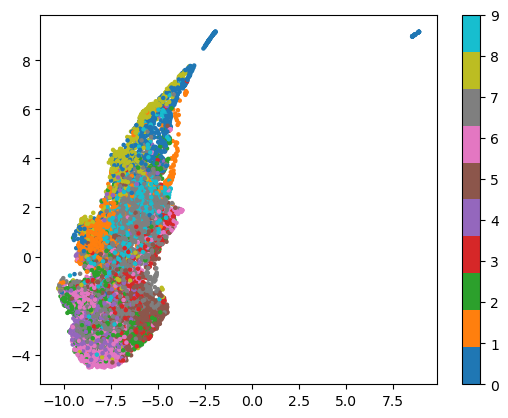

In [17]:
robust_feature_net = nn.Sequential(*list(robust_net.resnet.children())[:-1]).to(device)
robust_net.eval()
robust_feature_net.eval()
with torch.no_grad():
    for inputs, outputs in test_loader:
        inputs = inputs.to(device)
        features = robust_feature_net(inputs).squeeze().cpu().numpy()
        y_test = nn.functional.softmax(robust_net(inputs), dim=1).argmax(dim=1).cpu().numpy()

plot_umap(features,y_test)

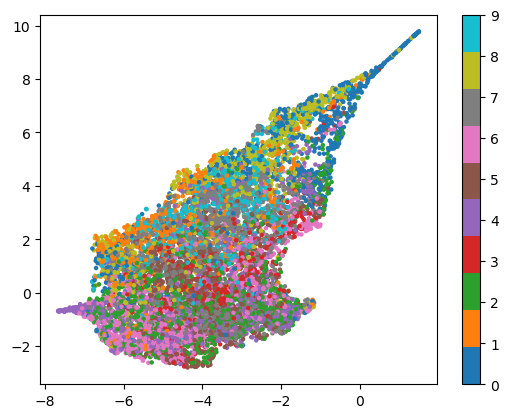

In [18]:
robust_net.eval()
robust_feature_net.eval()
with torch.no_grad():
    for inputs, outputs in test_loader_aug:
        inputs = inputs.to(device)
        with torch.enable_grad():
            # attacker = torchattacks.FGSM(robust_model, eps=FGSM_EPS)
            # inputs = attacker(inputs, outputs)
            inputs = fast_gradient_method(robust_net, inputs, eps=FGSM_EPS, norm=np.inf)
        features = robust_feature_net(inputs).squeeze().cpu().numpy()
        advy_test = nn.functional.softmax(robust_net(inputs), dim=1).argmax(dim=1).cpu().numpy()

plot_umap(features,advy_test)

##Question2 - Diffusion Model (45 points)

This homework helps you implement a Denoising Diffusion Probabilistic Model (DDPM).  



You can add any extra libraries that you need in this cell.

In [1]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import torch.nn as nn
from matplotlib import pyplot as plt
from PIL import Image
from keras.datasets import cifar10
from diffusers import UNet2DModel, DDPMScheduler

2024-04-03 03:32:17.907689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/u1/wxshi/miniconda3/envs/cs480/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/u1/wxshi/miniconda3/envs/cs480/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Q2.1 Load Data (5 points)

In this question, you are going to use one arbitrary class of CIFAR-10 dataset. First, load this dataset, then choose any class you want and use that for the rest of this question.

In [3]:
#Load the data and choose one class, then create the data loader.
train_data, test_data = cifar10.load_data()

In [4]:
# filter for one class
CLASS = 1

trainset = [x for x, y in zip(train_data[0], train_data[1]) if y == CLASS]

In [5]:
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.transform = transform
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            return self.transform(image)
        return image


preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataloader = DataLoader(CustomDataset(trainset, transform=preprocess), batch_size=64, shuffle=True)

In [6]:
def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid = Image.fromarray(np.array(grid).astype(np.uint8))
    return grid

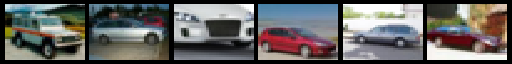

In [7]:
x_test = next(iter(dataloader))[:6]
show_images(x_test).resize((8 * 64, 64), resample=Image.NEAREST)

###Q2.2 Forward pass (10 points)

In this section, you are going to implement the forward pass of your diffusion model. You can use diffusers library for this task. Then use show_images function to plot your target image at different times of the forward pass. (Simply use the default hypermeters mentioned in the DDPM paper or the default values of the diffuser library. Visualising images every 100 steps is enough)

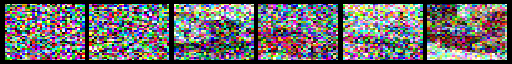

In [8]:
noise_scheduler = DDPMScheduler()

def forward_pass(inputs, scheduler):
    batch_size = inputs.shape[0]

    timesteps = 100 * torch.randint(
                low=1, 
                high=10,
                size=(batch_size,),
                device=inputs.device,
                dtype=torch.int64
            )

    noise = torch.randn(inputs.shape, device=inputs.device)
    noisy_inputs = scheduler.add_noise(inputs, noise, timesteps)

    return noisy_inputs, noise, timesteps

example, _, _ = forward_pass(x_test, noise_scheduler)
show_images(example).resize((8 * 64, 64), resample=Image.NEAREST)

###Q2.3 Denoising (15 points)

In this section, you will implement the denoising part of your diffusion model. First, create a U-net and train it on your CIFAR10 data. Then, start from random noise and plot the denoised images of 6 random samples. (In the DDPM paper Sec 3.3, they also trained a reverse process decoder. You are not required to implement it in this assignment. Visualizing the outputs of the diffusion network is sufficient.)

In [9]:
model = UNet2DModel(
    sample_size=32,
 )
model = model.to(device)

In [10]:
def train(unet_model,data_loader,criterion,optimizer):

    average_train_loss = 0

    with tqdm(data_loader, desc ="train") as train_tqdm:
        for batch_idx, inputs in enumerate(train_tqdm):
            model.train()
            clean_images = inputs.to(device)

            optimizer.zero_grad()
            noisy_images, noise, timesteps = forward_pass(clean_images, noise_scheduler)
            noise_pred = unet_model(noisy_images, timesteps, return_dict=False)[0]
            loss = criterion(noise_pred, noise)
            loss.backward()
            optimizer.step()

            average_train_loss += loss.item()  
    average_train_loss /= len(data_loader)
            
    return average_train_loss


In [13]:
NUM_EPOCHS = 100
for i in range(NUM_EPOCHS):
    average_train_loss = train(model, dataloader, nn.functional.mse_loss, torch.optim.AdamW(model.parameters(), lr=1e-4))
    print(f"   Epoch {i + 1} - Train Loss: {average_train_loss}")

train: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]


   Epoch 1 - Train Loss: 0.023740209886639177


train: 100%|██████████| 79/79 [00:24<00:00,  3.21it/s]


   Epoch 2 - Train Loss: 0.02308550159906662


train: 100%|██████████| 79/79 [00:24<00:00,  3.20it/s]


   Epoch 3 - Train Loss: 0.023538578466712673


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 4 - Train Loss: 0.02280926999129072


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 5 - Train Loss: 0.023263538008720816


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 6 - Train Loss: 0.0227267732254312


train: 100%|██████████| 79/79 [00:25<00:00,  3.16it/s]


   Epoch 7 - Train Loss: 0.022718946213680733


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 8 - Train Loss: 0.02283476526507094


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 9 - Train Loss: 0.023202183008005348


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 10 - Train Loss: 0.023081835854468467


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 11 - Train Loss: 0.022562183038909223


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 12 - Train Loss: 0.023333945252661463


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 13 - Train Loss: 0.02376940673146444


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 14 - Train Loss: 0.02301279141838792


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 15 - Train Loss: 0.02322912711320044


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 16 - Train Loss: 0.022378969554423908


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 17 - Train Loss: 0.023055716311629816


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 18 - Train Loss: 0.023556049017212057


train: 100%|██████████| 79/79 [00:24<00:00,  3.16it/s]


   Epoch 19 - Train Loss: 0.02248393131207816


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 20 - Train Loss: 0.02343814464026614


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 21 - Train Loss: 0.022579200801592838


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 22 - Train Loss: 0.02328180559451067


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 23 - Train Loss: 0.022093226543710202


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 24 - Train Loss: 0.02318614204944689


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 25 - Train Loss: 0.022106360361168656


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 26 - Train Loss: 0.022775771638637858


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 27 - Train Loss: 0.022362431134038335


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 28 - Train Loss: 0.022213156146433533


train: 100%|██████████| 79/79 [00:25<00:00,  3.16it/s]


   Epoch 29 - Train Loss: 0.022791473077067845


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 30 - Train Loss: 0.022435319574573374


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 31 - Train Loss: 0.021818515349509595


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 32 - Train Loss: 0.021850890821859807


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 33 - Train Loss: 0.021723596756405467


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 34 - Train Loss: 0.02170808041538996


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 35 - Train Loss: 0.022361478473566756


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 36 - Train Loss: 0.022199693949350827


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 37 - Train Loss: 0.02268432917757125


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 38 - Train Loss: 0.022421941939222662


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 39 - Train Loss: 0.021896868543345716


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 40 - Train Loss: 0.021304755365546747


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 41 - Train Loss: 0.02134357728771394


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 42 - Train Loss: 0.022056511355729044


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 43 - Train Loss: 0.02337576741281944


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 44 - Train Loss: 0.021342179113173786


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 45 - Train Loss: 0.02148929114536017


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 46 - Train Loss: 0.02214724940684023


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 47 - Train Loss: 0.021463930312119708


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 48 - Train Loss: 0.02254115680492


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 49 - Train Loss: 0.021120425702744645


train: 100%|██████████| 79/79 [00:25<00:00,  3.16it/s]


   Epoch 50 - Train Loss: 0.022253759335019167


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 51 - Train Loss: 0.021634009313074094


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 52 - Train Loss: 0.02167514322584943


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 53 - Train Loss: 0.02177114458165214


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 54 - Train Loss: 0.022127638853897777


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 55 - Train Loss: 0.02132397279426267


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 56 - Train Loss: 0.022416240134854104


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 57 - Train Loss: 0.021602440236395674


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 58 - Train Loss: 0.02170755083472291


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 59 - Train Loss: 0.02194052559759798


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 60 - Train Loss: 0.021450540086230898


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 61 - Train Loss: 0.02185252012944297


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 62 - Train Loss: 0.02165642688404533


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 63 - Train Loss: 0.021828951060630476


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 64 - Train Loss: 0.02137584249854465


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 65 - Train Loss: 0.02205822933936798


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 66 - Train Loss: 0.021877001381561727


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 67 - Train Loss: 0.021988975426441508


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 68 - Train Loss: 0.021094195833547585


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 69 - Train Loss: 0.02198574295904063


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 70 - Train Loss: 0.021395249032898793


train: 100%|██████████| 79/79 [00:25<00:00,  3.14it/s]


   Epoch 71 - Train Loss: 0.020449086045256897


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 72 - Train Loss: 0.02076363726224326


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 73 - Train Loss: 0.02138559067551094


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 74 - Train Loss: 0.022699591621190687


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 75 - Train Loss: 0.021392095633605612


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 76 - Train Loss: 0.02185288250823564


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 77 - Train Loss: 0.021351870196529583


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 78 - Train Loss: 0.020983833383438708


train: 100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


   Epoch 79 - Train Loss: 0.02113324955483026


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 80 - Train Loss: 0.021605082422117644


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 81 - Train Loss: 0.021300829263238966


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 82 - Train Loss: 0.020225846432620966


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 83 - Train Loss: 0.021264340009398853


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 84 - Train Loss: 0.021414742133096805


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 85 - Train Loss: 0.02117843126665942


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 86 - Train Loss: 0.021477790360775174


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 87 - Train Loss: 0.021283862039541142


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 88 - Train Loss: 0.021034580867596065


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 89 - Train Loss: 0.02087372220769713


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 90 - Train Loss: 0.021621453823356687


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 91 - Train Loss: 0.020620357775707032


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 92 - Train Loss: 0.021498158951348895


train: 100%|██████████| 79/79 [00:25<00:00,  3.16it/s]


   Epoch 93 - Train Loss: 0.021021053418988668


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 94 - Train Loss: 0.02143934858326293


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 95 - Train Loss: 0.021231187448565718


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 96 - Train Loss: 0.020936802854832216


train: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


   Epoch 97 - Train Loss: 0.02025502671405107


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 98 - Train Loss: 0.02136389854588086


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


   Epoch 99 - Train Loss: 0.02156112389049575


train: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]

   Epoch 100 - Train Loss: 0.021158416555086268


100%|██████████| 1000/1000 [00:21<00:00, 47.43it/s]


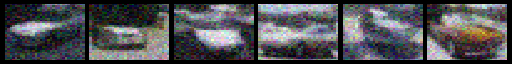

In [15]:
sample = torch.randn(6, 3, 32, 32).to(device)

#denoise
for t in tqdm(noise_scheduler.timesteps):
    with torch.no_grad():
        noisy_residual = model(sample, t).sample
    previous_noisy_sample = noise_scheduler.step(noisy_residual, t, sample).prev_sample
    sample = previous_noisy_sample

show_images(sample).resize((8 * 64, 64), resample=Image.NEAREST)


###Q2.4 Conditional Equation (15 points)

In this part, you should express $\alpha_t$ in terms of the values of $\beta_i$, in the following equation:

$$q(z_t|z_0) = \mathcal{N}(z_t; \sqrt{\alpha_t}z_0, (1-\alpha_t)I)$$

Take this into account that the conditional variance for the one step forward diffusion (the following equation) at time t is given by $\beta_t$.

$$q(z_t|z_{t-1}) = \mathcal{N}(z_t; \sqrt{1-\beta_t}z_{t-1}, \beta_tI)$$

solution:

If we want to sample:
$$z_T \sim q( z_T | z_{ T - 1 } ) = \mathcal N \left(z_T ; \sqrt{ 1 - \beta_T } z_{ T - 1 }, \beta_T I \right)$$
for all $T=1,2,\ldots$

Then by re-parameterization trick, we get:
$$z_T = \sqrt{ 1 - \beta_T } z_{ T - 1 } + \sqrt { \beta_T } \epsilon$$
where $\epsilon \sim \mathcal N ( 0, 1 )$.

Let $a_t = 1 - \beta_t$. Then we get:

$$\begin{align*}
z_t &= \sqrt{ a_t } z_{ t - 1 } + \sqrt { 1 - a_t } \epsilon \\
&= \sqrt{ a_t } \left(\sqrt{ a_{t-1} } z_{ t - 2 } + \sqrt { 1 - a_{t-1} } \epsilon\right) + \sqrt { 1 - a_t } \epsilon \\
&= \sqrt{a_ta_{t-1}}z_{t-2}+\sqrt{a_t(1-a_{t-1})}\epsilon + \sqrt { 1 - a_t } \epsilon
\end{align*}$$

By re-parameterization again, the latter two terms imply:
- $0 + \sqrt{a_t(1-a_{t-1})}\epsilon \to X\sim \mathcal N(0, a_t(1-a_{t-1}))$
- $0 + \sqrt { 1 - a_t } \epsilon \to Y\sim \mathcal N(0, 1 - a_t)$

$X$ and $Y$ are IID _(at least, we assume that the two terms are independently sampled)_, so we have:
$$X+Y\sim \mathcal N(0, a_t(1-a_{t-1}) + 1 - a_t)=\mathcal N(0, 1-a_ta_{t-1})$$

Thus we get:
$$\begin{align*}
z_t=& \sqrt{a_ta_{t-1}}z_{t-2} + \sqrt{1-a_ta_{t-1}}\epsilon \\
&\vdots \\
=& \sqrt{a_ta_{t-1}\ldots a_1}z_{0} + \sqrt{1-a_ta_{t-1}\ldots a_1}\epsilon
\end{align*}$$

Let $\alpha_t=\prod_{T=1}^ta_T$. Then we are left with:
$$ z_t = \sqrt{\alpha_t}z_{0} + \sqrt{1-\alpha_t}\epsilon $$

Therefore, by reparameterization again, 
$$z_t\sim q(z_t|z_0)=\mathcal N(z_t; \sqrt{\alpha_t}z_{0}, (1-\alpha_t)I)$$